In [2]:
from __future__ import division
import cv2,matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np


In [3]:
def show(img):
    plt.figure(figsize=(15,15))
    plt.imshow(img,interpolation='nearest')
    
def show_hsv(hsv):
    rgb=cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    show(rgb)

def show_mask(mask):
    plt.figure(figsize=(10,10))
    plt.imshow(mask,cmap="gray")
    
def overlay_mask(mask,img):
    rgb_mask=cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    img=cv2.addWeighted(rgb_mask,0.5,img,0.5,0)
    show(img)

In [27]:
image=cv2.imread("ripe_tom.jpg")

In [28]:
import pandas as pd
m,n,r=image.shape
arr=image.reshape(m*n,-1)
df=pd.DataFrame(arr,columns=['b','g','r'])
df.describe()

,b,g,r
count,2.654091e+06,2.654091e+06,2.654091e+06
mean,5.434512e+01,6.718292e+01,1.218235e+02
std,4.979917e+01,5.009713e+01,7.265688e+01
min,0.000000e+00,8.000000e+00,1.100000e+01
25%,3.000000e+01,3.400000e+01,3.500000e+01
50%,3.400000e+01,4.100000e+01,1.210000e+02
75%,4.600000e+01,8.100000e+01,1.840000e+02
max,2.550000e+02,2.470000e+02,2.550000e+02


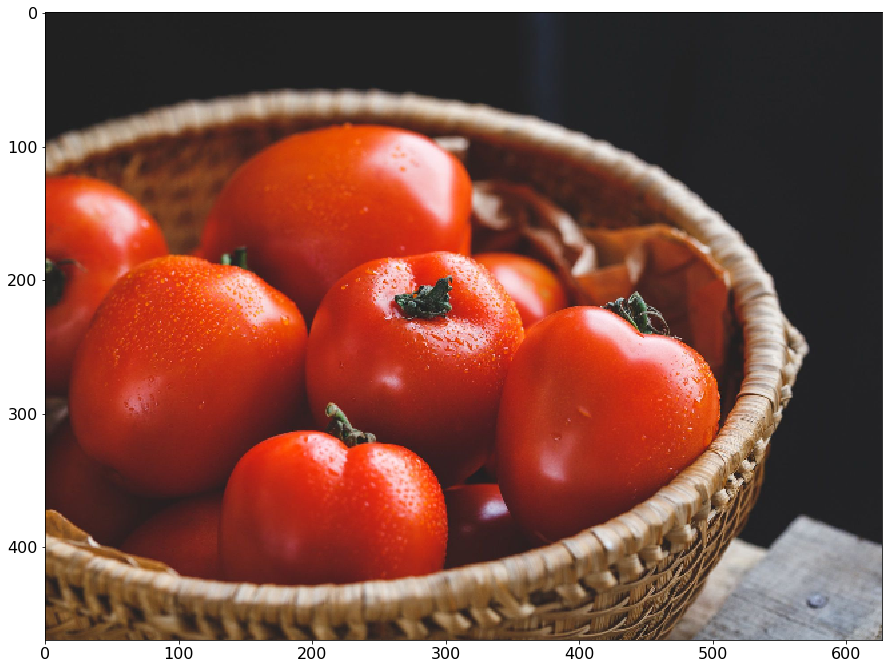

In [29]:
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,None,fx=1/3,fy=1/3)
show(image)


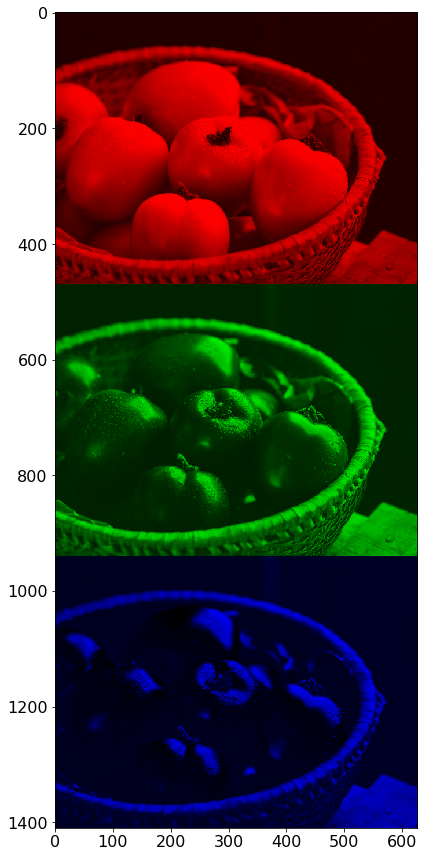

In [30]:
images=[]
for i in [0,1,2]:
    color=image.copy()
    if i!=0: color[:,:,0]=0
    if i!=1: color[:,:,1]=0
    if i!=2: color[:,:,2]=0
    images.append(color)
show(np.vstack(images))

In [31]:
def show_rgb_hist(img):
    colours=('r','g','b')
    for i,c in enumerate(colours):
        plt.figure(figsize=(20,4))
        histr=cv2.calcHist([image],[i],None,[256],[0,256])
        if c == 'r': colours = [((i/256, 0, 0)) for i in range(0, 256)]
        if c == 'g': colours = [((0, i/256, 0)) for i in range(0, 256)]
        if c == 'b': colours = [((0, 0, i/256)) for i in range(0, 256)]
        
        plt.bar(range(0, 256), histr, color=colours, edgecolor=colours, width=1)
#         plt.xlim([0, 256])

        plt.show()
        
    show_rgb_hist(image)

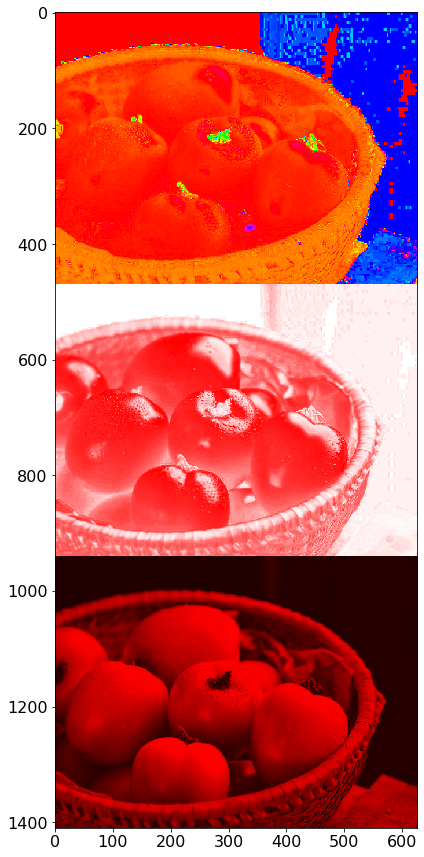

In [32]:
# Convert from RGB to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

images = []
for i in [0, 1, 2]:
    colour = hsv.copy()
    if i != 0: colour[:,:,0] = 0
    if i != 1: colour[:,:,1] = 255
    if i != 2: colour[:,:,2] = 255
    images.append(colour)
    
hsv_stack = np.vstack(images)
rgb_stack = cv2.cvtColor(hsv_stack, cv2.COLOR_HSV2RGB)
show(rgb_stack)

In [33]:
matplotlib.rcParams.update({'font.size': 16})

def show_hsv_hist(image):
    # Hue
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [0], None, [180], [0, 180])
    plt.xlim([0, 180])
    colours = [colors.hsv_to_rgb((i/180, 1, 0.9)) for i in range(0, 180)]
    plt.bar(range(0, 180), histr, color=colours, edgecolor=colours, width=1)
    plt.title('Hue')

    # Saturation
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [1], None, [256], [0, 256])
    plt.xlim([0, 256])

    colours = [colors.hsv_to_rgb((0, i/256, 1)) for i in range(0, 256)]
    plt.bar(range(0, 256), histr, color=colours, edgecolor=colours, width=1)
    plt.title('Saturation')

    # Value
    plt.figure(figsize=(20, 3))
    histr = cv2.calcHist([image], [2], None, [256], [0, 256])
    plt.xlim([0, 256])

    colours = [colors.hsv_to_rgb((0, 1, i/256)) for i in range(0, 256)]
    plt.bar(range(0, 256), histr, color=colours, edgecolor=colours, width=1)
    plt.title('Value')

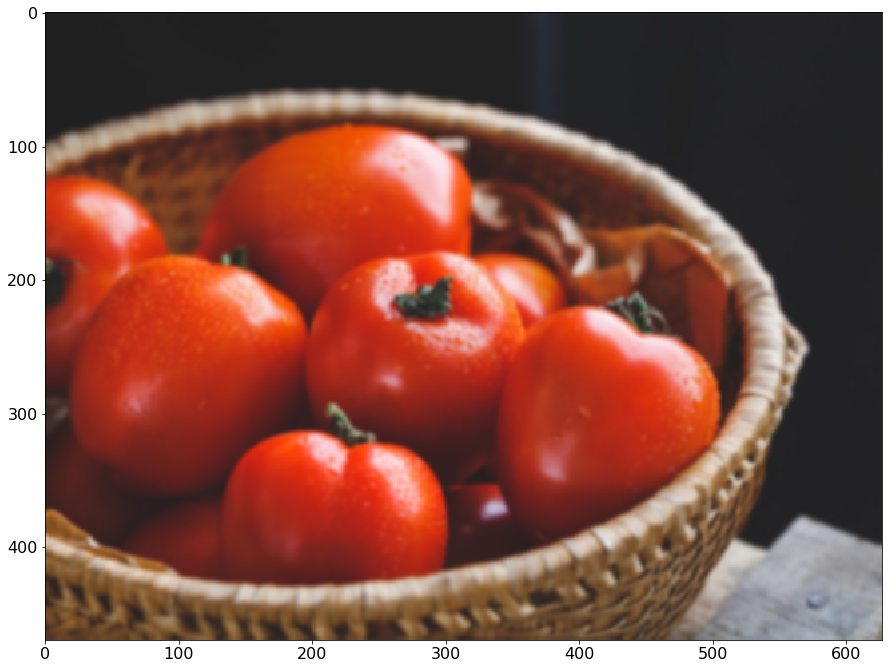

In [34]:
# Blur image slightly
image_blur = cv2.GaussianBlur(image, (7, 7), 0)
show(image_blur)



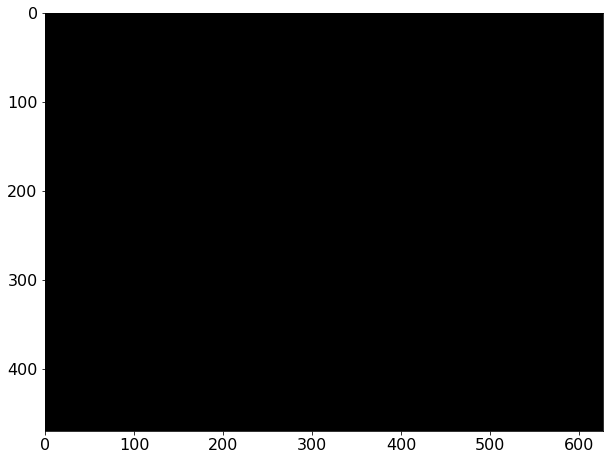

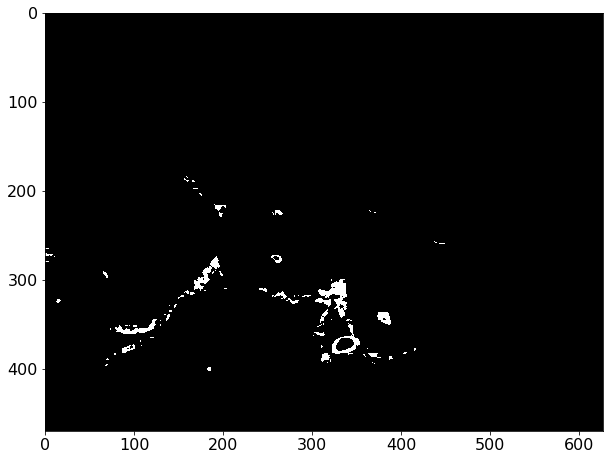

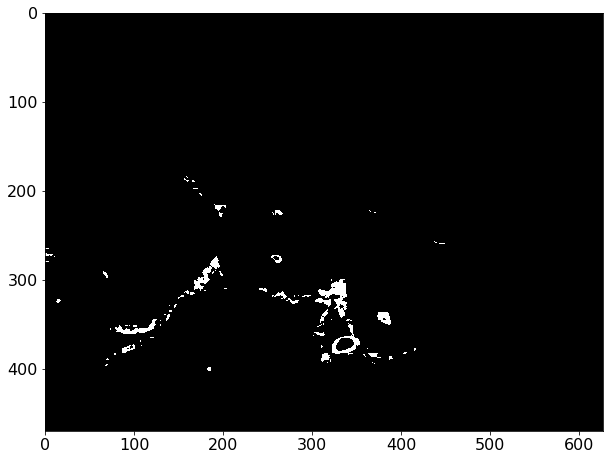

In [35]:
image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

# 0-10 hue
min_red = np.array([100, 100, 0])
max_red = np.array([55, 10, 51])
image_red1 = cv2.inRange(image_blur_hsv, min_red, max_red)

# 170-180 hue
min_red2 = np.array([170, 100, 60])
max_red2 = np.array([180, 256, 256])
image_red2 = cv2.inRange(image_blur_hsv, min_red2, max_red2)

show_mask(image_red1)
show_mask(image_red2)
image_red = image_red1 + image_red2
show_mask(image_red)


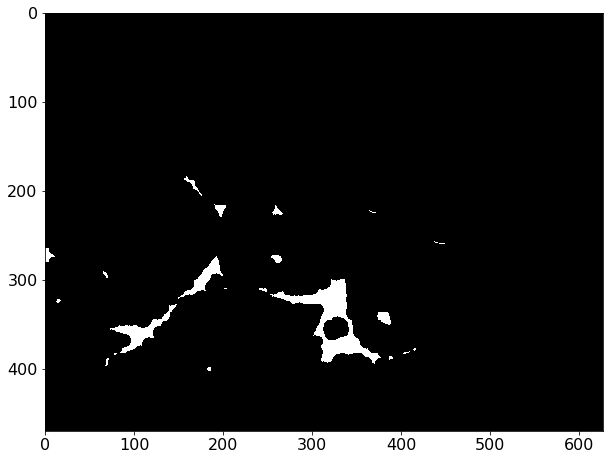

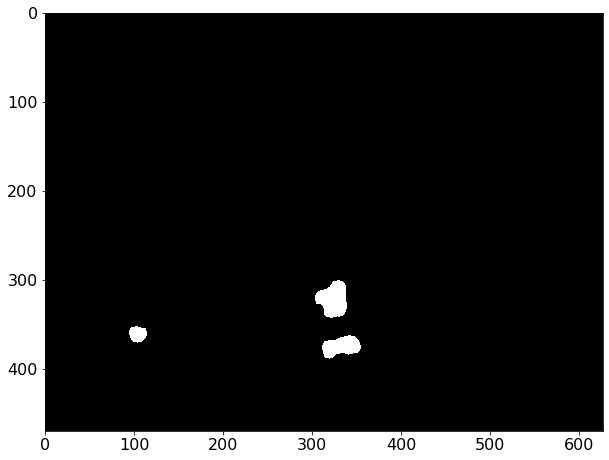

In [36]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
# Fill small gaps
image_red_closed = cv2.morphologyEx(image_red, cv2.MORPH_CLOSE, kernel)
show_mask(image_red_closed)

# Remove specks
image_red_closed_then_opened = cv2.morphologyEx(image_red_closed, cv2.MORPH_OPEN, kernel)
show_mask(image_red_closed_then_opened)


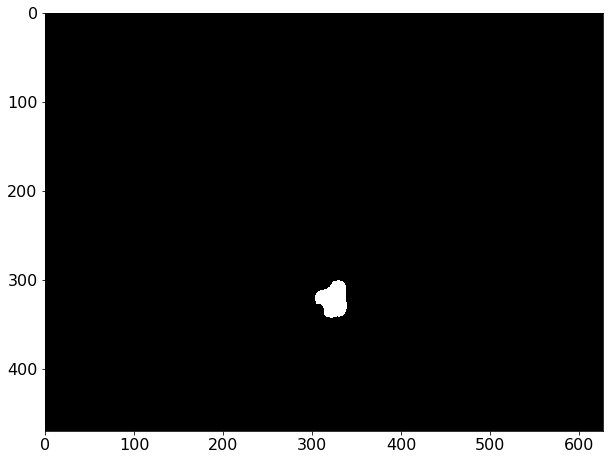

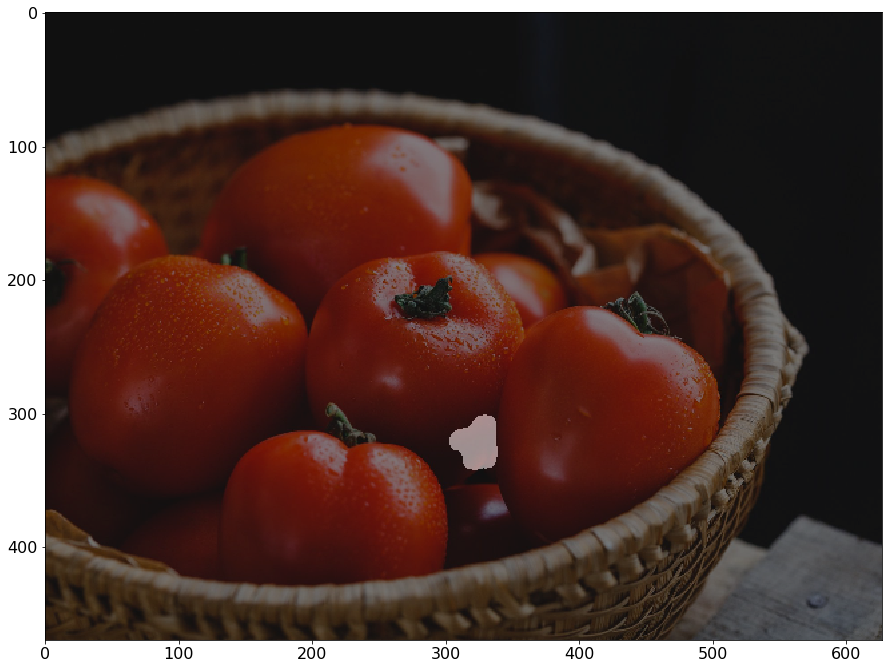

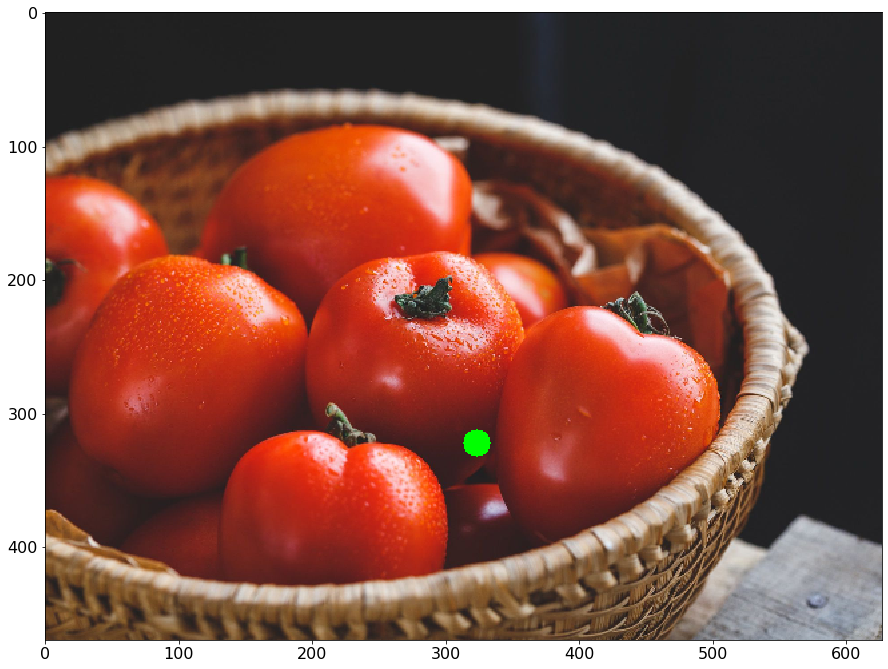

In [37]:
def find_biggest_contour(image):
    
    # Copy to prevent modification
    image = image.copy()
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #print len(contours)

    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
 
    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask

big_contour, red_mask = find_biggest_contour(image_red_closed_then_opened)
show_mask(red_mask)

overlay_mask(red_mask, image)


moments = cv2.moments(red_mask)
centre_of_mass = int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])
image_with_com = image.copy()
cv2.circle(image_with_com, centre_of_mass, 10, (0, 255, 0), -1)
show(image_with_com)


image_with_ellipse = image.copy()
ellipse = cv2.fitEllipse(big_contour)
cv2.ellipse(image_with_ellipse, ellipse, (0,255,0), 2)
show(image_with_ellipse)

